In [1]:
import numpy as np
from tqdm import tqdm
import boto3
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from models import MobileNetV3
from models import ViT

from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import prune_model, remove_pruning, count_nonzero_parameters, store_pruning_masks, reapply_pruning_masks, evaluate_model, plot_losses

import pickle
import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = "ck"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

label_encoder_dir = f'{data}/models'
label_encoder_path = f'final_label_encoder_{data}.pkl'

with open(label_encoder_path, 'wb') as file:
    pickle.dump(label_encoder, file)

s3 = boto3.client('s3')
s3.upload_file(label_encoder_path, bucket_name, os.path.join(label_encoder_dir, label_encoder_path))

os.remove(label_encoder_path)

In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
student_model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
teacher_model = ViT(num_labels=len(label_encoder.classes_)).to(device)

teacher_model.load_state_dict(torch.load(f'vit_{data}_best_model.pt',weights_only=False))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.0001)

In [9]:
def train_model(teacher,
                student,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                epochs,
                device="cpu",
                prune_percent=0.2,
                total_prune_cycles=100,
                patience=10,
                cycle_patience=3,
                T=2,
                soft_target_loss_weight=0.25,
                ce_loss_weight=0.75):

    best_models_dict = {}
    best_model_wts = copy.deepcopy(student.state_dict())
    global_best_val_loss = np.inf
    train_losses = []
    val_losses = []

    initial_params = count_nonzero_parameters(student)
    print(f"Initial non-zero parameters: {initial_params}")

    no_improvement_cycles = 0

    for cycle in range(total_prune_cycles):
        print(f"Pruning cycle {cycle + 1}/{total_prune_cycles}")

        current_params = count_nonzero_parameters(student)
        print(f"Params before cycle {cycle + 1}: {current_params}")

        cycle_best_val_loss = np.inf
        cycle_best_model_wts = copy.deepcopy(student.state_dict())
        no_improvement_epochs = 0

        for epoch in range(epochs):
            student.train()
            total_train_loss = 0

            for images, labels in tqdm(train_loader, desc=f"Cycle {cycle + 1}, Epoch {epoch + 1}"):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.no_grad():
                    teacher_logits = teacher(images).logits

                student_logits = student(images)

                soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
                soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

                soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

                label_loss = criterion(student_logits, labels)

                loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
                loss.backward()
                
                for name, param in student.named_parameters():
                    if hasattr(param, 'mask'):
                        param.grad *= param.mask
                        
                optimizer.step()

                total_train_loss += loss.item()

                del images, labels, student_logits, loss, teacher_logits
                torch.cuda.empty_cache()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            student.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = student(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

                    del images, labels, outputs, loss
                    torch.cuda.empty_cache()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

            if avg_val_loss < cycle_best_val_loss:
                cycle_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(student)
                remove_pruning(student)
                cycle_best_model_wts = copy.deepcopy(student.state_dict())
                reapply_pruning_masks(student, pruning_masks)
                
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            if avg_val_loss < global_best_val_loss:
                global_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(student)
                remove_pruning(student)
                best_model_wts = copy.deepcopy(student.state_dict())
                reapply_pruning_masks(student, pruning_masks)

            if no_improvement_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1} of cycle {cycle + 1}")
                break

        print(f"Cycle best loss: {cycle_best_val_loss}")
        print(f"Global best loss: {global_best_val_loss}")
        if cycle_best_val_loss == global_best_val_loss:
            global_best_val_loss = cycle_best_val_loss
            no_improvement_cycles = 0
            print(f"New global best validation loss: {global_best_val_loss:.4f} at cycle {cycle + 1}")
        else:
            no_improvement_cycles += 1
            print(f"No improvement in cycle {cycle + 1}. Cycle patience: {no_improvement_cycles}/{cycle_patience}")

        if no_improvement_cycles >= cycle_patience:
            print(f"Early stopping after {cycle + 1} cycles with no improvement.")
            break

        pruning_masks = store_pruning_masks(student)
        remove_pruning(student)
        
        student.load_state_dict(cycle_best_model_wts)
            
        best_models_dict[cycle + 1] = {
            'cycle': cycle + 1,
            'model': copy.deepcopy(student.state_dict()),
            'params': count_nonzero_parameters(student),
            'min_val_loss': cycle_best_val_loss
        }
        
        reapply_pruning_masks(student, pruning_masks)
        
        try:

            prune_model(student, prune_percent)
        except:
            print("Achieved max amount for pruning")
            current_params = count_nonzero_parameters(student)
            print(f"Parameters after cycle {cycle + 1}: {current_params}")
            break

        current_params = count_nonzero_parameters(student)
        print(f"Parameters after cycle {cycle + 1}: {current_params}")

    remove_pruning(student)
    student.load_state_dict(best_model_wts)

    final_params = count_nonzero_parameters(student)
    print(f"Best model count of paramenters: {final_params}")

    return student, best_models_dict, train_losses, val_losses

best_model, best_models_dict, train_loss, val_loss = train_model(
                                    teacher=teacher_model,
                                    student=student_model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    device=device,
                                    epochs=500,
                                    patience=10,
                                    cycle_patience=10,
                                    prune_percent=0.1,
                                    total_prune_cycles=20,
                                    T=8)

Initial non-zero parameters: 1515056
Pruning cycle 1/20
Params before cycle 1: 1515056


Cycle 1, Epoch 1: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch 1, Train Loss: 2.0472, Validation Loss: 1.7848


Cycle 1, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 2, Train Loss: 1.7515, Validation Loss: 1.5732


Cycle 1, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 3, Train Loss: 1.5002, Validation Loss: 1.3733


Cycle 1, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 4, Train Loss: 1.3177, Validation Loss: 1.2505


Cycle 1, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 5, Train Loss: 1.1448, Validation Loss: 1.1122


Cycle 1, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 6, Train Loss: 0.9688, Validation Loss: 0.9960


Cycle 1, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 7, Train Loss: 0.8507, Validation Loss: 0.9804


Cycle 1, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 8, Train Loss: 0.6956, Validation Loss: 0.9344


Cycle 1, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 9, Train Loss: 0.6174, Validation Loss: 0.8828


Cycle 1, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 10, Train Loss: 0.5432, Validation Loss: 0.8891


Cycle 1, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 11, Train Loss: 0.4805, Validation Loss: 0.8023


Cycle 1, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 12, Train Loss: 0.4229, Validation Loss: 0.6817


Cycle 1, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 13, Train Loss: 0.3690, Validation Loss: 0.7228


Cycle 1, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 14, Train Loss: 0.3321, Validation Loss: 0.6350


Cycle 1, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 15, Train Loss: 0.3095, Validation Loss: 0.6119


Cycle 1, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 16, Train Loss: 0.2738, Validation Loss: 0.6058


Cycle 1, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 17, Train Loss: 0.2438, Validation Loss: 0.5784


Cycle 1, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 18, Train Loss: 0.2146, Validation Loss: 0.5821


Cycle 1, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 19, Train Loss: 0.2096, Validation Loss: 0.5591


Cycle 1, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.1857, Validation Loss: 0.5904


Cycle 1, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 21, Train Loss: 0.1772, Validation Loss: 0.6324


Cycle 1, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 22, Train Loss: 0.1647, Validation Loss: 0.5540


Cycle 1, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 23, Train Loss: 0.1528, Validation Loss: 0.5894


Cycle 1, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 24, Train Loss: 0.1454, Validation Loss: 0.5951


Cycle 1, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 25, Train Loss: 0.1332, Validation Loss: 0.6232


Cycle 1, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 26, Train Loss: 0.1344, Validation Loss: 0.5810


Cycle 1, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.1274, Validation Loss: 0.5271


Cycle 1, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 28, Train Loss: 0.1218, Validation Loss: 0.5260


Cycle 1, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 29, Train Loss: 0.1137, Validation Loss: 0.5108


Cycle 1, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 30, Train Loss: 0.1069, Validation Loss: 0.5556


Cycle 1, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 31, Train Loss: 0.1095, Validation Loss: 0.5602


Cycle 1, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 32, Train Loss: 0.1136, Validation Loss: 0.5081


Cycle 1, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 33, Train Loss: 0.1006, Validation Loss: 0.4267


Cycle 1, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 34, Train Loss: 0.0976, Validation Loss: 0.3641


Cycle 1, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 35, Train Loss: 0.0850, Validation Loss: 0.3224


Cycle 1, Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 36, Train Loss: 0.0900, Validation Loss: 0.3638


Cycle 1, Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 37, Train Loss: 0.0856, Validation Loss: 0.2984


Cycle 1, Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 38, Train Loss: 0.0967, Validation Loss: 0.2784


Cycle 1, Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 39, Train Loss: 0.0857, Validation Loss: 0.2239


Cycle 1, Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 40, Train Loss: 0.0836, Validation Loss: 0.1867


Cycle 1, Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 41, Train Loss: 0.0799, Validation Loss: 0.1575


Cycle 1, Epoch 42: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 42, Train Loss: 0.0758, Validation Loss: 0.1690


Cycle 1, Epoch 43: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 43, Train Loss: 0.0718, Validation Loss: 0.1374


Cycle 1, Epoch 44: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 44, Train Loss: 0.0734, Validation Loss: 0.1571


Cycle 1, Epoch 45: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 45, Train Loss: 0.0731, Validation Loss: 0.1349


Cycle 1, Epoch 46: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 46, Train Loss: 0.0727, Validation Loss: 0.1275


Cycle 1, Epoch 47: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 47, Train Loss: 0.0709, Validation Loss: 0.1242


Cycle 1, Epoch 48: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 48, Train Loss: 0.0708, Validation Loss: 0.1168


Cycle 1, Epoch 49: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 49, Train Loss: 0.0722, Validation Loss: 0.1347


Cycle 1, Epoch 50: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 50, Train Loss: 0.0662, Validation Loss: 0.1089


Cycle 1, Epoch 51: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 51, Train Loss: 0.0666, Validation Loss: 0.1222


Cycle 1, Epoch 52: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 52, Train Loss: 0.0645, Validation Loss: 0.1095


Cycle 1, Epoch 53: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 53, Train Loss: 0.0642, Validation Loss: 0.1096


Cycle 1, Epoch 54: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 54, Train Loss: 0.0601, Validation Loss: 0.1164


Cycle 1, Epoch 55: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 55, Train Loss: 0.0635, Validation Loss: 0.1188


Cycle 1, Epoch 56: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 56, Train Loss: 0.0610, Validation Loss: 0.1332


Cycle 1, Epoch 57: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 57, Train Loss: 0.0601, Validation Loss: 0.1210


Cycle 1, Epoch 58: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 58, Train Loss: 0.0540, Validation Loss: 0.1200


Cycle 1, Epoch 59: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 59, Train Loss: 0.0597, Validation Loss: 0.1221


Cycle 1, Epoch 60: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 60, Train Loss: 0.0567, Validation Loss: 0.1285
Early stopping triggered at epoch 60 of cycle 1
Cycle best loss: 0.10891727637499571
Global best loss: 0.10891727637499571
New global best validation loss: 0.1089 at cycle 1
Parameters after cycle 1: 1364157
Pruning cycle 2/20
Params before cycle 2: 1364157


Cycle 2, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch 1, Train Loss: 0.0705, Validation Loss: 0.1717


Cycle 2, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 2, Train Loss: 0.0684, Validation Loss: 0.1327


Cycle 2, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 3, Train Loss: 0.0601, Validation Loss: 0.1381


Cycle 2, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 4, Train Loss: 0.0640, Validation Loss: 0.1703


Cycle 2, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 5, Train Loss: 0.0604, Validation Loss: 0.1428


Cycle 2, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 6, Train Loss: 0.0625, Validation Loss: 0.1472


Cycle 2, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 7, Train Loss: 0.0613, Validation Loss: 0.1103


Cycle 2, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 8, Train Loss: 0.0568, Validation Loss: 0.1263


Cycle 2, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 9, Train Loss: 0.0652, Validation Loss: 0.1366


Cycle 2, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 10, Train Loss: 0.0609, Validation Loss: 0.1157


Cycle 2, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 11, Train Loss: 0.0569, Validation Loss: 0.1285


Cycle 2, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 12, Train Loss: 0.0567, Validation Loss: 0.1099


Cycle 2, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 13, Train Loss: 0.0563, Validation Loss: 0.1063


Cycle 2, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 14, Train Loss: 0.0526, Validation Loss: 0.1094


Cycle 2, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 15, Train Loss: 0.0536, Validation Loss: 0.1086


Cycle 2, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 16, Train Loss: 0.0524, Validation Loss: 0.1176


Cycle 2, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 17, Train Loss: 0.0532, Validation Loss: 0.1199


Cycle 2, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 18, Train Loss: 0.0497, Validation Loss: 0.1125


Cycle 2, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 19, Train Loss: 0.0518, Validation Loss: 0.1128


Cycle 2, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 20, Train Loss: 0.0487, Validation Loss: 0.0965


Cycle 2, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 21, Train Loss: 0.0519, Validation Loss: 0.1118


Cycle 2, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 22, Train Loss: 0.0542, Validation Loss: 0.0987


Cycle 2, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 23, Train Loss: 0.0532, Validation Loss: 0.1197


Cycle 2, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 24, Train Loss: 0.0505, Validation Loss: 0.1011


Cycle 2, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 25, Train Loss: 0.0511, Validation Loss: 0.0909


Cycle 2, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 26, Train Loss: 0.0510, Validation Loss: 0.1174


Cycle 2, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.0505, Validation Loss: 0.1187


Cycle 2, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 28, Train Loss: 0.0481, Validation Loss: 0.1164


Cycle 2, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 29, Train Loss: 0.0461, Validation Loss: 0.1165


Cycle 2, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 30, Train Loss: 0.0451, Validation Loss: 0.1083


Cycle 2, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 31, Train Loss: 0.0472, Validation Loss: 0.0985


Cycle 2, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 32, Train Loss: 0.0451, Validation Loss: 0.0960


Cycle 2, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 33, Train Loss: 0.0486, Validation Loss: 0.1046


Cycle 2, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 34, Train Loss: 0.0426, Validation Loss: 0.1050


Cycle 2, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 35, Train Loss: 0.0431, Validation Loss: 0.1165
Early stopping triggered at epoch 35 of cycle 2
Cycle best loss: 0.09089144552126527
Global best loss: 0.09089144552126527
New global best validation loss: 0.0909 at cycle 2
Parameters after cycle 2: 1228348
Pruning cycle 3/20
Params before cycle 3: 1228348


Cycle 3, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 1, Train Loss: 0.0538, Validation Loss: 0.6211


Cycle 3, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 2, Train Loss: 0.0535, Validation Loss: 0.4671


Cycle 3, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 3, Train Loss: 0.0480, Validation Loss: 0.2904


Cycle 3, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 4, Train Loss: 0.0482, Validation Loss: 0.2362


Cycle 3, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 5, Train Loss: 0.0491, Validation Loss: 0.1774


Cycle 3, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 6, Train Loss: 0.0478, Validation Loss: 0.1459


Cycle 3, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 7, Train Loss: 0.0462, Validation Loss: 0.1588


Cycle 3, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 8, Train Loss: 0.0462, Validation Loss: 0.1397


Cycle 3, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 9, Train Loss: 0.0441, Validation Loss: 0.1290


Cycle 3, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 10, Train Loss: 0.0451, Validation Loss: 0.0993


Cycle 3, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 11, Train Loss: 0.0443, Validation Loss: 0.1187


Cycle 3, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 12, Train Loss: 0.0424, Validation Loss: 0.1201


Cycle 3, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 13, Train Loss: 0.0482, Validation Loss: 0.1124


Cycle 3, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 14, Train Loss: 0.0430, Validation Loss: 0.1155


Cycle 3, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 15, Train Loss: 0.0424, Validation Loss: 0.1080


Cycle 3, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 16, Train Loss: 0.0394, Validation Loss: 0.0995


Cycle 3, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 17, Train Loss: 0.0435, Validation Loss: 0.1015


Cycle 3, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 18, Train Loss: 0.0429, Validation Loss: 0.1084


Cycle 3, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 19, Train Loss: 0.0417, Validation Loss: 0.1236


Cycle 3, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.0450, Validation Loss: 0.1079
Early stopping triggered at epoch 20 of cycle 3
Cycle best loss: 0.09933632728643715
Global best loss: 0.09089144552126527
No improvement in cycle 3. Cycle patience: 1/10
Parameters after cycle 3: 1106117
Pruning cycle 4/20
Params before cycle 4: 1106117


Cycle 4, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 1, Train Loss: 0.0551, Validation Loss: 0.6607


Cycle 4, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 2, Train Loss: 0.0509, Validation Loss: 0.6627


Cycle 4, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 3, Train Loss: 0.0484, Validation Loss: 0.3683


Cycle 4, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 4, Train Loss: 0.0470, Validation Loss: 0.3558


Cycle 4, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 5, Train Loss: 0.0446, Validation Loss: 0.2422


Cycle 4, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 6, Train Loss: 0.0500, Validation Loss: 0.2430


Cycle 4, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 7, Train Loss: 0.0436, Validation Loss: 0.1732


Cycle 4, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 8, Train Loss: 0.0452, Validation Loss: 0.1374


Cycle 4, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 9, Train Loss: 0.0428, Validation Loss: 0.1495


Cycle 4, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 10, Train Loss: 0.0418, Validation Loss: 0.1105


Cycle 4, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 11, Train Loss: 0.0473, Validation Loss: 0.1066


Cycle 4, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 12, Train Loss: 0.0403, Validation Loss: 0.1105


Cycle 4, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 13, Train Loss: 0.0468, Validation Loss: 0.1274


Cycle 4, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 14, Train Loss: 0.0419, Validation Loss: 0.0927


Cycle 4, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 15, Train Loss: 0.0395, Validation Loss: 0.0987


Cycle 4, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 16, Train Loss: 0.0387, Validation Loss: 0.0851


Cycle 4, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 17, Train Loss: 0.0391, Validation Loss: 0.0929


Cycle 4, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 18, Train Loss: 0.0400, Validation Loss: 0.0902


Cycle 4, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 19, Train Loss: 0.0375, Validation Loss: 0.0883


Cycle 4, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.0386, Validation Loss: 0.1088


Cycle 4, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 21, Train Loss: 0.0395, Validation Loss: 0.0943


Cycle 4, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 22, Train Loss: 0.0400, Validation Loss: 0.0981


Cycle 4, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 23, Train Loss: 0.0404, Validation Loss: 0.0926


Cycle 4, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 24, Train Loss: 0.0371, Validation Loss: 0.1059


Cycle 4, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 25, Train Loss: 0.0396, Validation Loss: 0.1054


Cycle 4, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 26, Train Loss: 0.0382, Validation Loss: 0.0818


Cycle 4, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 27, Train Loss: 0.0422, Validation Loss: 0.0862


Cycle 4, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 28, Train Loss: 0.0401, Validation Loss: 0.1134


Cycle 4, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 29, Train Loss: 0.0392, Validation Loss: 0.0956


Cycle 4, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 30, Train Loss: 0.0368, Validation Loss: 0.0966


Cycle 4, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 31, Train Loss: 0.0389, Validation Loss: 0.1067


Cycle 4, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 32, Train Loss: 0.0376, Validation Loss: 0.1027


Cycle 4, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 33, Train Loss: 0.0360, Validation Loss: 0.0951


Cycle 4, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 34, Train Loss: 0.0355, Validation Loss: 0.1030


Cycle 4, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 35, Train Loss: 0.0379, Validation Loss: 0.1221


Cycle 4, Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 36, Train Loss: 0.0376, Validation Loss: 0.1217
Early stopping triggered at epoch 36 of cycle 4
Cycle best loss: 0.08177518472075462
Global best loss: 0.08177518472075462
New global best validation loss: 0.0818 at cycle 4
Parameters after cycle 4: 996107
Pruning cycle 5/20
Params before cycle 5: 996107


Cycle 5, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 1, Train Loss: 0.0632, Validation Loss: 1.1011


Cycle 5, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 2, Train Loss: 0.0534, Validation Loss: 0.9858


Cycle 5, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 3, Train Loss: 0.0457, Validation Loss: 0.7475


Cycle 5, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.0427, Validation Loss: 0.5107


Cycle 5, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 5, Train Loss: 0.0410, Validation Loss: 0.4304


Cycle 5, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 6, Train Loss: 0.0413, Validation Loss: 0.3180


Cycle 5, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 7, Train Loss: 0.0427, Validation Loss: 0.2325


Cycle 5, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 8, Train Loss: 0.0431, Validation Loss: 0.1452


Cycle 5, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 9, Train Loss: 0.0464, Validation Loss: 0.1614


Cycle 5, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 10, Train Loss: 0.0452, Validation Loss: 0.1342


Cycle 5, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 11, Train Loss: 0.0370, Validation Loss: 0.1299


Cycle 5, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 12, Train Loss: 0.0381, Validation Loss: 0.1260


Cycle 5, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 13, Train Loss: 0.0358, Validation Loss: 0.1167


Cycle 5, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 14, Train Loss: 0.0372, Validation Loss: 0.0999


Cycle 5, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 15, Train Loss: 0.0352, Validation Loss: 0.1130


Cycle 5, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 16, Train Loss: 0.0354, Validation Loss: 0.1156


Cycle 5, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 17, Train Loss: 0.0351, Validation Loss: 0.1029


Cycle 5, Epoch 18: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch 18, Train Loss: 0.0378, Validation Loss: 0.1033


Cycle 5, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 19, Train Loss: 0.0374, Validation Loss: 0.1014


Cycle 5, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 20, Train Loss: 0.0375, Validation Loss: 0.0978


Cycle 5, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 21, Train Loss: 0.0367, Validation Loss: 0.0944


Cycle 5, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 22, Train Loss: 0.0351, Validation Loss: 0.1007


Cycle 5, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 23, Train Loss: 0.0379, Validation Loss: 0.0848


Cycle 5, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 24, Train Loss: 0.0367, Validation Loss: 0.0909


Cycle 5, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 25, Train Loss: 0.0376, Validation Loss: 0.1071


Cycle 5, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 26, Train Loss: 0.0361, Validation Loss: 0.0825


Cycle 5, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.0351, Validation Loss: 0.0947


Cycle 5, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 28, Train Loss: 0.0344, Validation Loss: 0.1041


Cycle 5, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 29, Train Loss: 0.0358, Validation Loss: 0.1023


Cycle 5, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 30, Train Loss: 0.0379, Validation Loss: 0.1028


Cycle 5, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 31, Train Loss: 0.0336, Validation Loss: 0.1091


Cycle 5, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 32, Train Loss: 0.0335, Validation Loss: 0.1005


Cycle 5, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 33, Train Loss: 0.0349, Validation Loss: 0.0880


Cycle 5, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 34, Train Loss: 0.0362, Validation Loss: 0.0994


Cycle 5, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 35, Train Loss: 0.0333, Validation Loss: 0.1014


Cycle 5, Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 36, Train Loss: 0.0337, Validation Loss: 0.0873
Early stopping triggered at epoch 36 of cycle 5
Cycle best loss: 0.08246598567347974
Global best loss: 0.08177518472075462
No improvement in cycle 5. Cycle patience: 1/10
Parameters after cycle 5: 897098
Pruning cycle 6/20
Params before cycle 6: 897098


Cycle 6, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 1, Train Loss: 0.0608, Validation Loss: 0.8478


Cycle 6, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 2, Train Loss: 0.0469, Validation Loss: 0.5696


Cycle 6, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 3, Train Loss: 0.0450, Validation Loss: 0.3563


Cycle 6, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.0439, Validation Loss: 0.2531


Cycle 6, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 5, Train Loss: 0.0403, Validation Loss: 0.2292


Cycle 6, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 6, Train Loss: 0.0392, Validation Loss: 0.2524


Cycle 6, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 7, Train Loss: 0.0399, Validation Loss: 0.1822


Cycle 6, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 8, Train Loss: 0.0367, Validation Loss: 0.1511


Cycle 6, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 9, Train Loss: 0.0371, Validation Loss: 0.1406


Cycle 6, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 10, Train Loss: 0.0366, Validation Loss: 0.1255


Cycle 6, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 11, Train Loss: 0.0350, Validation Loss: 0.1107


Cycle 6, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 12, Train Loss: 0.0341, Validation Loss: 0.1184


Cycle 6, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 13, Train Loss: 0.0364, Validation Loss: 0.1113


Cycle 6, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 14, Train Loss: 0.0341, Validation Loss: 0.1034


Cycle 6, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 15, Train Loss: 0.0373, Validation Loss: 0.1036


Cycle 6, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 16, Train Loss: 0.0369, Validation Loss: 0.0956


Cycle 6, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 17, Train Loss: 0.0326, Validation Loss: 0.0950


Cycle 6, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 18, Train Loss: 0.0356, Validation Loss: 0.0898


Cycle 6, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 19, Train Loss: 0.0330, Validation Loss: 0.0997


Cycle 6, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.0346, Validation Loss: 0.0992


Cycle 6, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 21, Train Loss: 0.0361, Validation Loss: 0.1274


Cycle 6, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 22, Train Loss: 0.0342, Validation Loss: 0.0803


Cycle 6, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 23, Train Loss: 0.0340, Validation Loss: 0.1035


Cycle 6, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 24, Train Loss: 0.0320, Validation Loss: 0.0978


Cycle 6, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 25, Train Loss: 0.0328, Validation Loss: 0.1119


Cycle 6, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 26, Train Loss: 0.0316, Validation Loss: 0.1023


Cycle 6, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.0329, Validation Loss: 0.1047


Cycle 6, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 28, Train Loss: 0.0304, Validation Loss: 0.0938


Cycle 6, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 29, Train Loss: 0.0332, Validation Loss: 0.0930


Cycle 6, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 30, Train Loss: 0.0306, Validation Loss: 0.0938


Cycle 6, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 31, Train Loss: 0.0317, Validation Loss: 0.0975


Cycle 6, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 32, Train Loss: 0.0321, Validation Loss: 0.1013
Early stopping triggered at epoch 32 of cycle 6
Cycle best loss: 0.08029544888995588
Global best loss: 0.08029544888995588
New global best validation loss: 0.0803 at cycle 6
Parameters after cycle 6: 807994
Pruning cycle 7/20
Params before cycle 7: 807994


Cycle 7, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 1, Train Loss: 0.0675, Validation Loss: 1.3374


Cycle 7, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 2, Train Loss: 0.0516, Validation Loss: 0.9148


Cycle 7, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 3, Train Loss: 0.0407, Validation Loss: 0.6887


Cycle 7, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 4, Train Loss: 0.0429, Validation Loss: 0.6131


Cycle 7, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 5, Train Loss: 0.0385, Validation Loss: 0.4897


Cycle 7, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 6, Train Loss: 0.0427, Validation Loss: 0.4294


Cycle 7, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 7, Train Loss: 0.0385, Validation Loss: 0.3013


Cycle 7, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 8, Train Loss: 0.0389, Validation Loss: 0.3125


Cycle 7, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 9, Train Loss: 0.0376, Validation Loss: 0.2023


Cycle 7, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 10, Train Loss: 0.0348, Validation Loss: 0.1542


Cycle 7, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 11, Train Loss: 0.0371, Validation Loss: 0.1368


Cycle 7, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 12, Train Loss: 0.0359, Validation Loss: 0.1250


Cycle 7, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 13, Train Loss: 0.0366, Validation Loss: 0.1371


Cycle 7, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 14, Train Loss: 0.0342, Validation Loss: 0.1124


Cycle 7, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 15, Train Loss: 0.0332, Validation Loss: 0.0996


Cycle 7, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 16, Train Loss: 0.0362, Validation Loss: 0.0859


Cycle 7, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 17, Train Loss: 0.0340, Validation Loss: 0.0959


Cycle 7, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 18, Train Loss: 0.0314, Validation Loss: 0.0876


Cycle 7, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 19, Train Loss: 0.0373, Validation Loss: 0.0890


Cycle 7, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.0345, Validation Loss: 0.0928


Cycle 7, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 21, Train Loss: 0.0323, Validation Loss: 0.1045


Cycle 7, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 22, Train Loss: 0.0343, Validation Loss: 0.1102


Cycle 7, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 23, Train Loss: 0.0356, Validation Loss: 0.0933


Cycle 7, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 24, Train Loss: 0.0325, Validation Loss: 0.0961


Cycle 7, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 25, Train Loss: 0.0313, Validation Loss: 0.0861


Cycle 7, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 26, Train Loss: 0.0308, Validation Loss: 0.0914
Early stopping triggered at epoch 26 of cycle 7
Cycle best loss: 0.08590757776983082
Global best loss: 0.08029544888995588
No improvement in cycle 7. Cycle patience: 1/10
Parameters after cycle 7: 727802
Pruning cycle 8/20
Params before cycle 8: 727802


Cycle 8, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 1, Train Loss: 0.1064, Validation Loss: 2.0727


Cycle 8, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 2, Train Loss: 0.0600, Validation Loss: 1.6597


Cycle 8, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 3, Train Loss: 0.0530, Validation Loss: 1.2458


Cycle 8, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 4, Train Loss: 0.0572, Validation Loss: 0.9771


Cycle 8, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 5, Train Loss: 0.0461, Validation Loss: 0.6992


Cycle 8, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 6, Train Loss: 0.0459, Validation Loss: 0.5181


Cycle 8, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 7, Train Loss: 0.0413, Validation Loss: 0.4566


Cycle 8, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 8, Train Loss: 0.0406, Validation Loss: 0.3332


Cycle 8, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 9, Train Loss: 0.0406, Validation Loss: 0.2318


Cycle 8, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 10, Train Loss: 0.0419, Validation Loss: 0.2261


Cycle 8, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 11, Train Loss: 0.0358, Validation Loss: 0.1849


Cycle 8, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 12, Train Loss: 0.0383, Validation Loss: 0.1632


Cycle 8, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 13, Train Loss: 0.0368, Validation Loss: 0.1289


Cycle 8, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 14, Train Loss: 0.0372, Validation Loss: 0.1368


Cycle 8, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 15, Train Loss: 0.0366, Validation Loss: 0.1177


Cycle 8, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 16, Train Loss: 0.0360, Validation Loss: 0.1102


Cycle 8, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 17, Train Loss: 0.0368, Validation Loss: 0.1114


Cycle 8, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 18, Train Loss: 0.0361, Validation Loss: 0.1045


Cycle 8, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 19, Train Loss: 0.0321, Validation Loss: 0.1182


Cycle 8, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 20, Train Loss: 0.0326, Validation Loss: 0.1068


Cycle 8, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 21, Train Loss: 0.0318, Validation Loss: 0.1103


Cycle 8, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 22, Train Loss: 0.0321, Validation Loss: 0.0910


Cycle 8, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 23, Train Loss: 0.0341, Validation Loss: 0.1246


Cycle 8, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 24, Train Loss: 0.0319, Validation Loss: 0.0996


Cycle 8, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 25, Train Loss: 0.0362, Validation Loss: 0.0919


Cycle 8, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 26, Train Loss: 0.0382, Validation Loss: 0.1195


Cycle 8, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 27, Train Loss: 0.0307, Validation Loss: 0.1113


Cycle 8, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 28, Train Loss: 0.0320, Validation Loss: 0.0991


Cycle 8, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 29, Train Loss: 0.0308, Validation Loss: 0.1068


Cycle 8, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 30, Train Loss: 0.0337, Validation Loss: 0.1300


Cycle 8, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 31, Train Loss: 0.0328, Validation Loss: 0.0972


Cycle 8, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 32, Train Loss: 0.0290, Validation Loss: 0.0939
Early stopping triggered at epoch 32 of cycle 8
Cycle best loss: 0.09097242495045066
Global best loss: 0.08029544888995588
No improvement in cycle 8. Cycle patience: 2/10
Parameters after cycle 8: 655622
Pruning cycle 9/20
Params before cycle 9: 655622


Cycle 9, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 1, Train Loss: 0.1064, Validation Loss: 1.7791


Cycle 9, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 2, Train Loss: 0.0606, Validation Loss: 1.1428


Cycle 9, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 3, Train Loss: 0.0526, Validation Loss: 0.8138


Cycle 9, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.0509, Validation Loss: 0.6054


Cycle 9, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 5, Train Loss: 0.0539, Validation Loss: 0.5231


Cycle 9, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 6, Train Loss: 0.0472, Validation Loss: 0.4200


Cycle 9, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 7, Train Loss: 0.0445, Validation Loss: 0.2414


Cycle 9, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 8, Train Loss: 0.0451, Validation Loss: 0.2026


Cycle 9, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 9, Train Loss: 0.0409, Validation Loss: 0.1569


Cycle 9, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 10, Train Loss: 0.0428, Validation Loss: 0.1789


Cycle 9, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 11, Train Loss: 0.0380, Validation Loss: 0.1295


Cycle 9, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 12, Train Loss: 0.0399, Validation Loss: 0.1088


Cycle 9, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 13, Train Loss: 0.0377, Validation Loss: 0.1159


Cycle 9, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 14, Train Loss: 0.0360, Validation Loss: 0.1016


Cycle 9, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 15, Train Loss: 0.0382, Validation Loss: 0.1095


Cycle 9, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 16, Train Loss: 0.0337, Validation Loss: 0.0934


Cycle 9, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 17, Train Loss: 0.0322, Validation Loss: 0.1245


Cycle 9, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 18, Train Loss: 0.0396, Validation Loss: 0.1258


Cycle 9, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 19, Train Loss: 0.0370, Validation Loss: 0.0996


Cycle 9, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 20, Train Loss: 0.0353, Validation Loss: 0.1187


Cycle 9, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 21, Train Loss: 0.0351, Validation Loss: 0.1147


Cycle 9, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 22, Train Loss: 0.0340, Validation Loss: 0.0971


Cycle 9, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 23, Train Loss: 0.0352, Validation Loss: 0.1012


Cycle 9, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 24, Train Loss: 0.0338, Validation Loss: 0.1240


Cycle 9, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 25, Train Loss: 0.0299, Validation Loss: 0.0986


Cycle 9, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 26, Train Loss: 0.0345, Validation Loss: 0.1083
Early stopping triggered at epoch 26 of cycle 9
Cycle best loss: 0.09343259991146624
Global best loss: 0.08029544888995588
No improvement in cycle 9. Cycle patience: 3/10
Parameters after cycle 9: 590669
Pruning cycle 10/20
Params before cycle 10: 590669


Cycle 10, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 1, Train Loss: 0.1212, Validation Loss: 2.4804


Cycle 10, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 2, Train Loss: 0.0832, Validation Loss: 2.2835


Cycle 10, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 3, Train Loss: 0.0589, Validation Loss: 2.0413


Cycle 10, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 4, Train Loss: 0.0567, Validation Loss: 1.5160


Cycle 10, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 5, Train Loss: 0.0466, Validation Loss: 0.9381


Cycle 10, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 6, Train Loss: 0.0465, Validation Loss: 0.5947


Cycle 10, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 7, Train Loss: 0.0432, Validation Loss: 0.3873


Cycle 10, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 8, Train Loss: 0.0443, Validation Loss: 0.3084


Cycle 10, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 9, Train Loss: 0.0401, Validation Loss: 0.2471


Cycle 10, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 10, Train Loss: 0.0407, Validation Loss: 0.1736


Cycle 10, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 11, Train Loss: 0.0401, Validation Loss: 0.1433


Cycle 10, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 12, Train Loss: 0.0400, Validation Loss: 0.1428


Cycle 10, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 13, Train Loss: 0.0383, Validation Loss: 0.1331


Cycle 10, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 14, Train Loss: 0.0411, Validation Loss: 0.1357


Cycle 10, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 15, Train Loss: 0.0398, Validation Loss: 0.1222


Cycle 10, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 16, Train Loss: 0.0364, Validation Loss: 0.1170


Cycle 10, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 17, Train Loss: 0.0366, Validation Loss: 0.1195


Cycle 10, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 18, Train Loss: 0.0364, Validation Loss: 0.1292


Cycle 10, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 19, Train Loss: 0.0347, Validation Loss: 0.1347


Cycle 10, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 20, Train Loss: 0.0394, Validation Loss: 0.0995


Cycle 10, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 21, Train Loss: 0.0368, Validation Loss: 0.0936


Cycle 10, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 22, Train Loss: 0.0327, Validation Loss: 0.0714


Cycle 10, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 23, Train Loss: 0.0371, Validation Loss: 0.1216


Cycle 10, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 24, Train Loss: 0.0392, Validation Loss: 0.1127


Cycle 10, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 25, Train Loss: 0.0335, Validation Loss: 0.1238


Cycle 10, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 26, Train Loss: 0.0359, Validation Loss: 0.1027


Cycle 10, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.0367, Validation Loss: 0.0866


Cycle 10, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 28, Train Loss: 0.0351, Validation Loss: 0.1062


Cycle 10, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 29, Train Loss: 0.0315, Validation Loss: 0.1028


Cycle 10, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 30, Train Loss: 0.0327, Validation Loss: 0.0991


Cycle 10, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 31, Train Loss: 0.0322, Validation Loss: 0.1242


Cycle 10, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 32, Train Loss: 0.0334, Validation Loss: 0.1198
Early stopping triggered at epoch 32 of cycle 10
Cycle best loss: 0.07144093990791589
Global best loss: 0.07144093990791589
New global best validation loss: 0.0714 at cycle 10
Parameters after cycle 10: 532205
Pruning cycle 11/20
Params before cycle 11: 532205


Cycle 11, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 1, Train Loss: 0.1443, Validation Loss: 2.8495


Cycle 11, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 2, Train Loss: 0.0745, Validation Loss: 2.2766


Cycle 11, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 3, Train Loss: 0.0614, Validation Loss: 1.8412


Cycle 11, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 4, Train Loss: 0.0533, Validation Loss: 1.3335


Cycle 11, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 5, Train Loss: 0.0499, Validation Loss: 1.1041


Cycle 11, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 6, Train Loss: 0.0482, Validation Loss: 0.8558


Cycle 11, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 7, Train Loss: 0.0458, Validation Loss: 0.4632


Cycle 11, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 8, Train Loss: 0.0499, Validation Loss: 0.4328


Cycle 11, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 9, Train Loss: 0.0426, Validation Loss: 0.3181


Cycle 11, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 10, Train Loss: 0.0409, Validation Loss: 0.2188


Cycle 11, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 11, Train Loss: 0.0409, Validation Loss: 0.2288


Cycle 11, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 12, Train Loss: 0.0423, Validation Loss: 0.1892


Cycle 11, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 13, Train Loss: 0.0474, Validation Loss: 0.1582


Cycle 11, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 14, Train Loss: 0.0415, Validation Loss: 0.1389


Cycle 11, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 15, Train Loss: 0.0397, Validation Loss: 0.1457


Cycle 11, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 16, Train Loss: 0.0388, Validation Loss: 0.1183


Cycle 11, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 17, Train Loss: 0.0409, Validation Loss: 0.1455


Cycle 11, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 18, Train Loss: 0.0364, Validation Loss: 0.1192


Cycle 11, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 19, Train Loss: 0.0399, Validation Loss: 0.1492


Cycle 11, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.0414, Validation Loss: 0.1425


Cycle 11, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 21, Train Loss: 0.0384, Validation Loss: 0.1537


Cycle 11, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 22, Train Loss: 0.0342, Validation Loss: 0.0909


Cycle 11, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 23, Train Loss: 0.0380, Validation Loss: 0.1017


Cycle 11, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 24, Train Loss: 0.0346, Validation Loss: 0.1409


Cycle 11, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 25, Train Loss: 0.0349, Validation Loss: 0.1045


Cycle 11, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 26, Train Loss: 0.0351, Validation Loss: 0.1097


Cycle 11, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 27, Train Loss: 0.0349, Validation Loss: 0.1413


Cycle 11, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 28, Train Loss: 0.0343, Validation Loss: 0.0975


Cycle 11, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 29, Train Loss: 0.0334, Validation Loss: 0.1033


Cycle 11, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 30, Train Loss: 0.0333, Validation Loss: 0.0881


Cycle 11, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 31, Train Loss: 0.0369, Validation Loss: 0.1178


Cycle 11, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 32, Train Loss: 0.0347, Validation Loss: 0.1204


Cycle 11, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 33, Train Loss: 0.0351, Validation Loss: 0.1123


Cycle 11, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 34, Train Loss: 0.0312, Validation Loss: 0.1273


Cycle 11, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 35, Train Loss: 0.0362, Validation Loss: 0.1375


Cycle 11, Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 36, Train Loss: 0.0361, Validation Loss: 0.1129


Cycle 11, Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 37, Train Loss: 0.0332, Validation Loss: 0.1085


Cycle 11, Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 38, Train Loss: 0.0369, Validation Loss: 0.1143


Cycle 11, Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 39, Train Loss: 0.0331, Validation Loss: 0.0929


Cycle 11, Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 40, Train Loss: 0.0351, Validation Loss: 0.1134
Early stopping triggered at epoch 40 of cycle 11
Cycle best loss: 0.08807827555574477
Global best loss: 0.07144093990791589
No improvement in cycle 11. Cycle patience: 1/10
Parameters after cycle 11: 479587
Pruning cycle 12/20
Params before cycle 12: 479587


Cycle 12, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 1, Train Loss: 0.2610, Validation Loss: 2.2031


Cycle 12, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 2, Train Loss: 0.1176, Validation Loss: 2.4656


Cycle 12, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 3, Train Loss: 0.0837, Validation Loss: 2.2385


Cycle 12, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 4, Train Loss: 0.0791, Validation Loss: 1.7328


Cycle 12, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 5, Train Loss: 0.0540, Validation Loss: 1.2937


Cycle 12, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 6, Train Loss: 0.0586, Validation Loss: 0.9892


Cycle 12, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 7, Train Loss: 0.0642, Validation Loss: 0.6397


Cycle 12, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 8, Train Loss: 0.0629, Validation Loss: 0.4564


Cycle 12, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 9, Train Loss: 0.0485, Validation Loss: 0.3893


Cycle 12, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 10, Train Loss: 0.0598, Validation Loss: 0.3847


Cycle 12, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 11, Train Loss: 0.0455, Validation Loss: 0.3442


Cycle 12, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 12, Train Loss: 0.0483, Validation Loss: 0.2791


Cycle 12, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 13, Train Loss: 0.0463, Validation Loss: 0.2787


Cycle 12, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 14, Train Loss: 0.0398, Validation Loss: 0.2437


Cycle 12, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 15, Train Loss: 0.0425, Validation Loss: 0.2071


Cycle 12, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 16, Train Loss: 0.0396, Validation Loss: 0.1967


Cycle 12, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 17, Train Loss: 0.0386, Validation Loss: 0.1729


Cycle 12, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 18, Train Loss: 0.0411, Validation Loss: 0.1647


Cycle 12, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 19, Train Loss: 0.0390, Validation Loss: 0.1644


Cycle 12, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 20, Train Loss: 0.0383, Validation Loss: 0.1322


Cycle 12, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 21, Train Loss: 0.0374, Validation Loss: 0.1639


Cycle 12, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 22, Train Loss: 0.0399, Validation Loss: 0.1265


Cycle 12, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 23, Train Loss: 0.0376, Validation Loss: 0.1373


Cycle 12, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 24, Train Loss: 0.0389, Validation Loss: 0.1421


Cycle 12, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 25, Train Loss: 0.0370, Validation Loss: 0.1184


Cycle 12, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 26, Train Loss: 0.0388, Validation Loss: 0.1383


Cycle 12, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.0394, Validation Loss: 0.1519


Cycle 12, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 28, Train Loss: 0.0366, Validation Loss: 0.1102


Cycle 12, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 29, Train Loss: 0.0365, Validation Loss: 0.1079


Cycle 12, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 30, Train Loss: 0.0375, Validation Loss: 0.1234


Cycle 12, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 31, Train Loss: 0.0413, Validation Loss: 0.1178


Cycle 12, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 32, Train Loss: 0.0351, Validation Loss: 0.1100


Cycle 12, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 33, Train Loss: 0.0380, Validation Loss: 0.0939


Cycle 12, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 34, Train Loss: 0.0382, Validation Loss: 0.1071


Cycle 12, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 35, Train Loss: 0.0373, Validation Loss: 0.1156


Cycle 12, Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 36, Train Loss: 0.0377, Validation Loss: 0.1044


Cycle 12, Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 37, Train Loss: 0.0355, Validation Loss: 0.1102


Cycle 12, Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 38, Train Loss: 0.0400, Validation Loss: 0.0977


Cycle 12, Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 39, Train Loss: 0.0369, Validation Loss: 0.1347


Cycle 12, Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 40, Train Loss: 0.0356, Validation Loss: 0.1184


Cycle 12, Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 41, Train Loss: 0.0347, Validation Loss: 0.1245


Cycle 12, Epoch 42: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 42, Train Loss: 0.0350, Validation Loss: 0.1151


Cycle 12, Epoch 43: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 43, Train Loss: 0.0340, Validation Loss: 0.1037
Early stopping triggered at epoch 43 of cycle 12
Cycle best loss: 0.09388601104728878
Global best loss: 0.07144093990791589
No improvement in cycle 12. Cycle patience: 2/10
Parameters after cycle 12: 432237
Pruning cycle 13/20
Params before cycle 13: 432237


Cycle 13, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 1, Train Loss: 0.1910, Validation Loss: 2.8046


Cycle 13, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 2, Train Loss: 0.1107, Validation Loss: 2.8837


Cycle 13, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 3, Train Loss: 0.0794, Validation Loss: 2.5780


Cycle 13, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 4, Train Loss: 0.0798, Validation Loss: 2.1433


Cycle 13, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 5, Train Loss: 0.0585, Validation Loss: 1.8335


Cycle 13, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 6, Train Loss: 0.0547, Validation Loss: 1.5220


Cycle 13, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 7, Train Loss: 0.0597, Validation Loss: 1.2684


Cycle 13, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 8, Train Loss: 0.0512, Validation Loss: 1.1150


Cycle 13, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 9, Train Loss: 0.0570, Validation Loss: 0.8534


Cycle 13, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 10, Train Loss: 0.0482, Validation Loss: 0.5880


Cycle 13, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 11, Train Loss: 0.0559, Validation Loss: 0.5952


Cycle 13, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 12, Train Loss: 0.0423, Validation Loss: 0.3871


Cycle 13, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 13, Train Loss: 0.0409, Validation Loss: 0.3265


Cycle 13, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 14, Train Loss: 0.0501, Validation Loss: 0.3177


Cycle 13, Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 15, Train Loss: 0.0497, Validation Loss: 0.2835


Cycle 13, Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 16, Train Loss: 0.0517, Validation Loss: 0.2233


Cycle 13, Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 17, Train Loss: 0.0400, Validation Loss: 0.2332


Cycle 13, Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 18, Train Loss: 0.0429, Validation Loss: 0.2686


Cycle 13, Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 19, Train Loss: 0.0467, Validation Loss: 0.1861


Cycle 13, Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 20, Train Loss: 0.0434, Validation Loss: 0.1603


Cycle 13, Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 21, Train Loss: 0.0387, Validation Loss: 0.1538


Cycle 13, Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 22, Train Loss: 0.0401, Validation Loss: 0.1681


Cycle 13, Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 23, Train Loss: 0.0385, Validation Loss: 0.1645


Cycle 13, Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 24, Train Loss: 0.0383, Validation Loss: 0.1635


Cycle 13, Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 25, Train Loss: 0.0362, Validation Loss: 0.1679


Cycle 13, Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 26, Train Loss: 0.0469, Validation Loss: 0.1339


Cycle 13, Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 27, Train Loss: 0.0363, Validation Loss: 0.1342


Cycle 13, Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 28, Train Loss: 0.0370, Validation Loss: 0.1507


Cycle 13, Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 29, Train Loss: 0.0414, Validation Loss: 0.1469


Cycle 13, Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 30, Train Loss: 0.0369, Validation Loss: 0.1373


Cycle 13, Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 31, Train Loss: 0.0374, Validation Loss: 0.1347


Cycle 13, Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 32, Train Loss: 0.0411, Validation Loss: 0.1351


Cycle 13, Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 33, Train Loss: 0.0368, Validation Loss: 0.1437


Cycle 13, Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 34, Train Loss: 0.0346, Validation Loss: 0.0959


Cycle 13, Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 35, Train Loss: 0.0388, Validation Loss: 0.1275


Cycle 13, Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 36, Train Loss: 0.0382, Validation Loss: 0.1506


Cycle 13, Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 37, Train Loss: 0.0353, Validation Loss: 0.1405


Cycle 13, Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 38, Train Loss: 0.0353, Validation Loss: 0.1379


Cycle 13, Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 39, Train Loss: 0.0336, Validation Loss: 0.1515


Cycle 13, Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 40, Train Loss: 0.0385, Validation Loss: 0.1018


Cycle 13, Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 41, Train Loss: 0.0369, Validation Loss: 0.1302


Cycle 13, Epoch 42: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 42, Train Loss: 0.0370, Validation Loss: 0.1474


Cycle 13, Epoch 43: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 43, Train Loss: 0.0342, Validation Loss: 0.1277


Cycle 13, Epoch 44: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 44, Train Loss: 0.0320, Validation Loss: 0.1254
Early stopping triggered at epoch 44 of cycle 13
Cycle best loss: 0.09592271875590086
Global best loss: 0.07144093990791589
No improvement in cycle 13. Cycle patience: 3/10
Parameters after cycle 13: 389614
Pruning cycle 14/20
Params before cycle 14: 389614


Cycle 14, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 1, Train Loss: 0.3328, Validation Loss: 3.0796


Cycle 14, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 2, Train Loss: 0.1453, Validation Loss: 2.5106


Cycle 14, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 3, Train Loss: 0.1038, Validation Loss: 2.3430


Cycle 14, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 4, Train Loss: 0.0823, Validation Loss: 2.4369


Cycle 14, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 5, Train Loss: 0.0779, Validation Loss: 2.4780


Cycle 14, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 6, Train Loss: 0.0767, Validation Loss: 2.4120


Cycle 14, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 7, Train Loss: 0.0761, Validation Loss: 3.2175


Cycle 14, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 8, Train Loss: 0.0581, Validation Loss: 4.6945


Cycle 14, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 9, Train Loss: 0.0575, Validation Loss: 5.1925


Cycle 14, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 10, Train Loss: 0.0554, Validation Loss: 5.3965


Cycle 14, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 11, Train Loss: 0.0567, Validation Loss: 5.0091


Cycle 14, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 12, Train Loss: 0.0528, Validation Loss: 4.8059


Cycle 14, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 13, Train Loss: 0.0562, Validation Loss: 4.3272
Early stopping triggered at epoch 13 of cycle 14
Cycle best loss: 2.342966452240944
Global best loss: 0.07144093990791589
No improvement in cycle 14. Cycle patience: 4/10
Parameters after cycle 14: 351256
Pruning cycle 15/20
Params before cycle 15: 351256


Cycle 15, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 1, Train Loss: 1.0191, Validation Loss: 3.5300


Cycle 15, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 2, Train Loss: 0.6559, Validation Loss: 2.3716


Cycle 15, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 3, Train Loss: 0.4388, Validation Loss: 4.8044


Cycle 15, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.3924, Validation Loss: 3.8140


Cycle 15, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 5, Train Loss: 0.3192, Validation Loss: 3.1394


Cycle 15, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 6, Train Loss: 0.3627, Validation Loss: 3.1738


Cycle 15, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 7, Train Loss: 0.2838, Validation Loss: 2.6029


Cycle 15, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 8, Train Loss: 0.2432, Validation Loss: 7.5954


Cycle 15, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 9, Train Loss: 0.2430, Validation Loss: 23.5758


Cycle 15, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 10, Train Loss: 0.2033, Validation Loss: 24.3327


Cycle 15, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 11, Train Loss: 0.2128, Validation Loss: 69.0673


Cycle 15, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 12, Train Loss: 0.1834, Validation Loss: 6.5748
Early stopping triggered at epoch 12 of cycle 15
Cycle best loss: 2.3716002255678177
Global best loss: 0.07144093990791589
No improvement in cycle 15. Cycle patience: 5/10
Parameters after cycle 15: 316734
Pruning cycle 16/20
Params before cycle 16: 316734


Cycle 16, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 1, Train Loss: 1.3545, Validation Loss: 3.2179


Cycle 16, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 2, Train Loss: 1.0713, Validation Loss: 2.6584


Cycle 16, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 3, Train Loss: 0.9243, Validation Loss: 2.6385


Cycle 16, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 4, Train Loss: 0.7948, Validation Loss: 5.9163


Cycle 16, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 5, Train Loss: 0.7168, Validation Loss: 7.0065


Cycle 16, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 6, Train Loss: 0.6520, Validation Loss: 6.4886


Cycle 16, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 7, Train Loss: 0.5861, Validation Loss: 10.1973


Cycle 16, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 8, Train Loss: 0.5497, Validation Loss: 17.6099


Cycle 16, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 9, Train Loss: 0.5103, Validation Loss: 36.6136


Cycle 16, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 10, Train Loss: 0.4529, Validation Loss: 47.4738


Cycle 16, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 11, Train Loss: 0.3868, Validation Loss: 88.4558


Cycle 16, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 12, Train Loss: 0.3724, Validation Loss: 240.4422


Cycle 16, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 13, Train Loss: 0.3814, Validation Loss: 1003.7189
Early stopping triggered at epoch 13 of cycle 16
Cycle best loss: 2.6384905576705933
Global best loss: 0.07144093990791589
No improvement in cycle 16. Cycle patience: 6/10
Parameters after cycle 16: 285667
Pruning cycle 17/20
Params before cycle 17: 285667


Cycle 17, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 1, Train Loss: 1.5499, Validation Loss: 30.9176


Cycle 17, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 2, Train Loss: 1.2736, Validation Loss: 20.1305


Cycle 17, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 3, Train Loss: 1.1724, Validation Loss: 30.6928


Cycle 17, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.9963, Validation Loss: 19.8866


Cycle 17, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 5, Train Loss: 1.0145, Validation Loss: 104.5832


Cycle 17, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 6, Train Loss: 0.9485, Validation Loss: 186.8286


Cycle 17, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 7, Train Loss: 0.8374, Validation Loss: 395.4958


Cycle 17, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 8, Train Loss: 0.8406, Validation Loss: 1012.0800


Cycle 17, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 9, Train Loss: 0.7529, Validation Loss: 601.0602


Cycle 17, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 10, Train Loss: 0.7053, Validation Loss: 367.5897


Cycle 17, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 11, Train Loss: 0.7112, Validation Loss: 1785.1823


Cycle 17, Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 12, Train Loss: 0.6427, Validation Loss: 2985.5894


Cycle 17, Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 13, Train Loss: 0.6489, Validation Loss: 4489.2782


Cycle 17, Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 14, Train Loss: 0.6769, Validation Loss: 5032.6054
Early stopping triggered at epoch 14 of cycle 17
Cycle best loss: 19.886645197868347
Global best loss: 0.07144093990791589
No improvement in cycle 17. Cycle patience: 7/10
Parameters after cycle 17: 257700
Pruning cycle 18/20
Params before cycle 18: 257700


Cycle 18, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 1, Train Loss: 2.0193, Validation Loss: 238.1760


Cycle 18, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 2, Train Loss: 1.7491, Validation Loss: 1083.4684


Cycle 18, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 3, Train Loss: 1.5599, Validation Loss: 2932.6094


Cycle 18, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 4, Train Loss: 1.4217, Validation Loss: 3968.2450


Cycle 18, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 5, Train Loss: 1.3220, Validation Loss: 3575.6183


Cycle 18, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 6, Train Loss: 1.3001, Validation Loss: 11331.0115


Cycle 18, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 7, Train Loss: 1.2087, Validation Loss: 2363.9525


Cycle 18, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 8, Train Loss: 1.1828, Validation Loss: 9348.5878


Cycle 18, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 9, Train Loss: 1.0946, Validation Loss: 9753.6965


Cycle 18, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 10, Train Loss: 1.0499, Validation Loss: 28838.0532


Cycle 18, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 11, Train Loss: 1.0224, Validation Loss: 54903.0869
Early stopping triggered at epoch 11 of cycle 18
Cycle best loss: 238.1760025024414
Global best loss: 0.07144093990791589
No improvement in cycle 18. Cycle patience: 8/10
Parameters after cycle 18: 232540
Pruning cycle 19/20
Params before cycle 19: 232540


Cycle 19, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 1, Train Loss: 2.0454, Validation Loss: 7.9378


Cycle 19, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 2, Train Loss: 1.9182, Validation Loss: 31.9557


Cycle 19, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 3, Train Loss: 1.8060, Validation Loss: 44.0244


Cycle 19, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 4, Train Loss: 1.7361, Validation Loss: 139.3818


Cycle 19, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 5, Train Loss: 1.6542, Validation Loss: 278.5176


Cycle 19, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 6, Train Loss: 1.5739, Validation Loss: 753.2032


Cycle 19, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 7, Train Loss: 1.5367, Validation Loss: 789.9359


Cycle 19, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 8, Train Loss: 1.4893, Validation Loss: 416.1994


Cycle 19, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 9, Train Loss: 1.4295, Validation Loss: 1436.6871


Cycle 19, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 10, Train Loss: 1.3509, Validation Loss: 1498.6961


Cycle 19, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 11, Train Loss: 1.3283, Validation Loss: 4491.6266
Early stopping triggered at epoch 11 of cycle 19
Cycle best loss: 7.937795996665955
Global best loss: 0.07144093990791589
No improvement in cycle 19. Cycle patience: 9/10
Parameters after cycle 19: 209887
Pruning cycle 20/20
Params before cycle 20: 209887


Cycle 20, Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 1, Train Loss: 2.0675, Validation Loss: 144.4406


Cycle 20, Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 2, Train Loss: 1.9963, Validation Loss: 993.6328


Cycle 20, Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 3, Train Loss: 1.9074, Validation Loss: 767.4372


Cycle 20, Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 4, Train Loss: 1.8736, Validation Loss: 2082.7544


Cycle 20, Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 5, Train Loss: 1.8545, Validation Loss: 1125.5279


Cycle 20, Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 6, Train Loss: 1.7801, Validation Loss: 3952.2428


Cycle 20, Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 7, Train Loss: 1.7249, Validation Loss: 1991.3511


Cycle 20, Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 8, Train Loss: 1.7136, Validation Loss: 1917.9305


Cycle 20, Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 9, Train Loss: 1.6557, Validation Loss: 5556.1993


Cycle 20, Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 10, Train Loss: 1.6541, Validation Loss: 5852.5550


Cycle 20, Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 11, Train Loss: 1.5902, Validation Loss: 9711.1602
Early stopping triggered at epoch 11 of cycle 20
Cycle best loss: 144.44061660766602
Global best loss: 0.07144093990791589
No improvement in cycle 20. Cycle patience: 10/10
Early stopping after 20 cycles with no improvement.
Best model count of paramenters: 590669


In [10]:
models_dict_dir = f'{data}/models'
models_dict_path = f'models_dict_{data}.pkl'

with open(models_dict_path, 'wb') as file:
    pickle.dump(best_models_dict, file)

s3 = boto3.client('s3')
s3.upload_file(models_dict_path, bucket_name, os.path.join(models_dict_dir, models_dict_path))

os.remove(models_dict_path)

Evaluating model from cycle 1, Parameters: 1515056, Min Val Loss: 0.1089


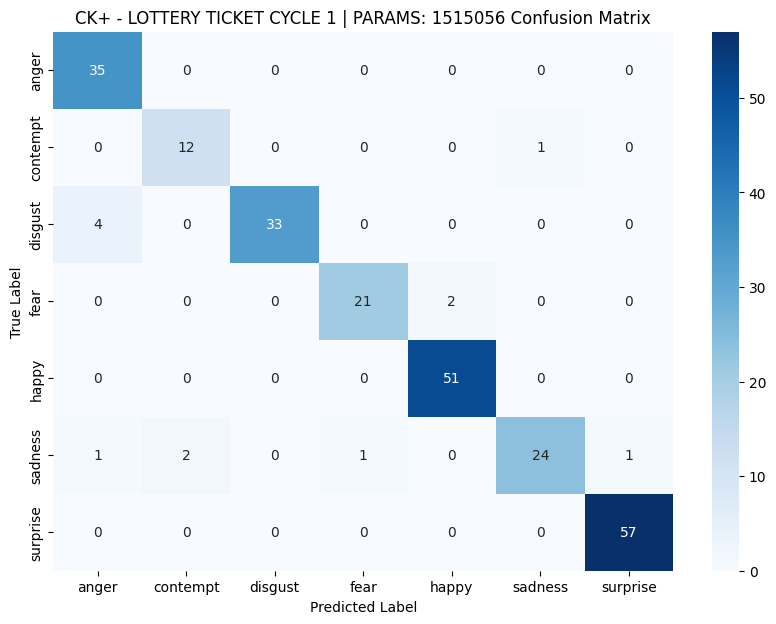

Test Accuracy: 0.9510
Precision: 0.9417
Recall: 0.9365
F1 Score: 0.9371
Classification Report:
               precision    recall  f1-score   support

       anger       0.88      1.00      0.93        35
    contempt       0.86      0.92      0.89        13
     disgust       1.00      0.89      0.94        37
        fear       0.95      0.91      0.93        23
       happy       0.96      1.00      0.98        51
     sadness       0.96      0.83      0.89        29
    surprise       0.98      1.00      0.99        57

    accuracy                           0.95       245
   macro avg       0.94      0.94      0.94       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 2, Parameters: 1364157, Min Val Loss: 0.0909


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


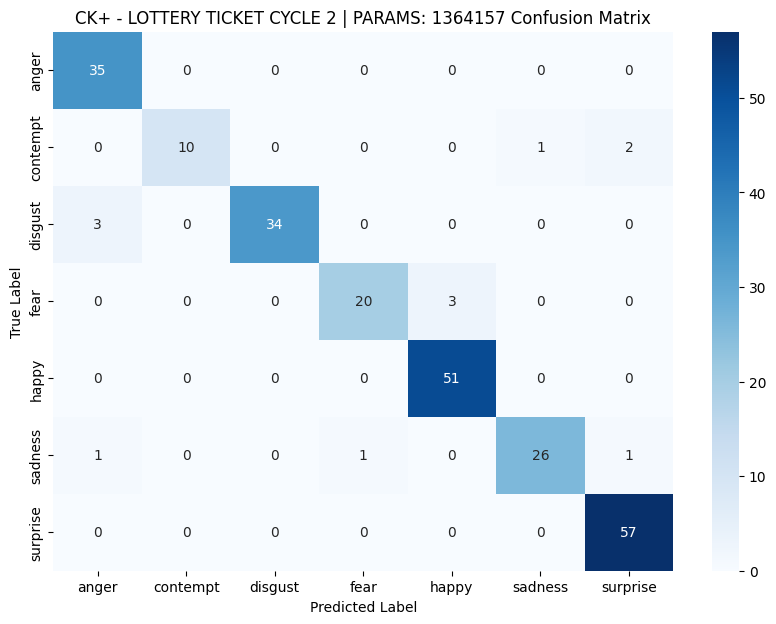

Test Accuracy: 0.9510
Precision: 0.9582
Recall: 0.9220
F1 Score: 0.9367
Classification Report:
               precision    recall  f1-score   support

       anger       0.90      1.00      0.95        35
    contempt       1.00      0.77      0.87        13
     disgust       1.00      0.92      0.96        37
        fear       0.95      0.87      0.91        23
       happy       0.94      1.00      0.97        51
     sadness       0.96      0.90      0.93        29
    surprise       0.95      1.00      0.97        57

    accuracy                           0.95       245
   macro avg       0.96      0.92      0.94       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 3, Parameters: 1228348, Min Val Loss: 0.0993


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


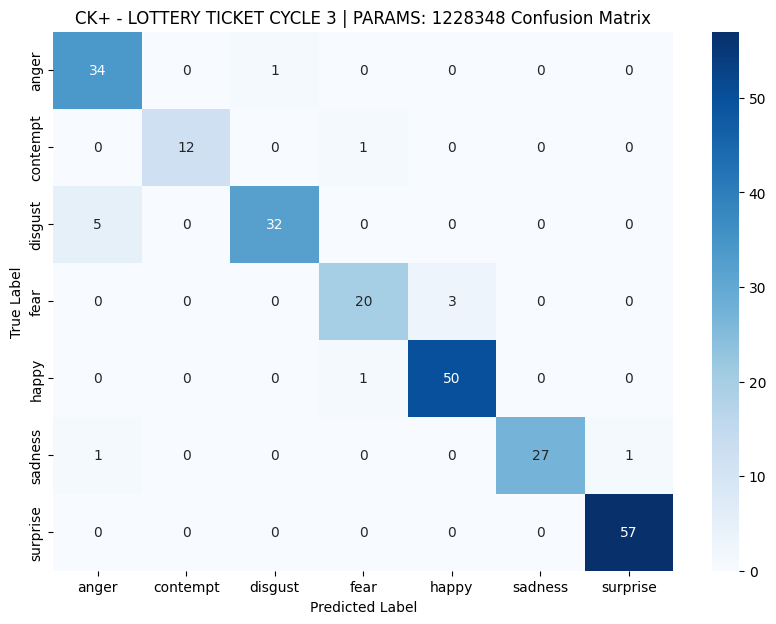

Test Accuracy: 0.9469
Precision: 0.9507
Recall: 0.9343
F1 Score: 0.9410
Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.97      0.91        35
    contempt       1.00      0.92      0.96        13
     disgust       0.97      0.86      0.91        37
        fear       0.91      0.87      0.89        23
       happy       0.94      0.98      0.96        51
     sadness       1.00      0.93      0.96        29
    surprise       0.98      1.00      0.99        57

    accuracy                           0.95       245
   macro avg       0.95      0.93      0.94       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 4, Parameters: 1106117, Min Val Loss: 0.0818


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


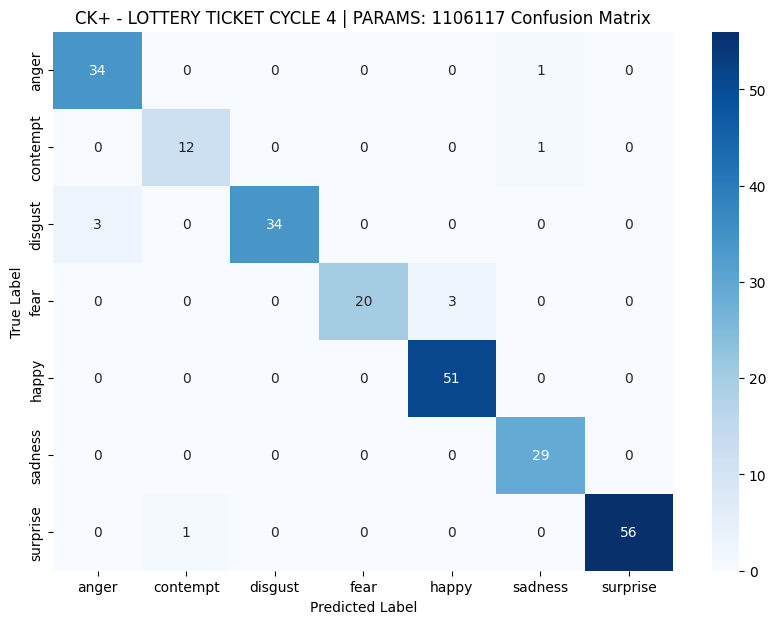

Test Accuracy: 0.9633
Precision: 0.9603
Recall: 0.9522
F1 Score: 0.9550
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.97      0.94        35
    contempt       0.92      0.92      0.92        13
     disgust       1.00      0.92      0.96        37
        fear       1.00      0.87      0.93        23
       happy       0.94      1.00      0.97        51
     sadness       0.94      1.00      0.97        29
    surprise       1.00      0.98      0.99        57

    accuracy                           0.96       245
   macro avg       0.96      0.95      0.95       245
weighted avg       0.97      0.96      0.96       245

Evaluating model from cycle 5, Parameters: 996107, Min Val Loss: 0.0825


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


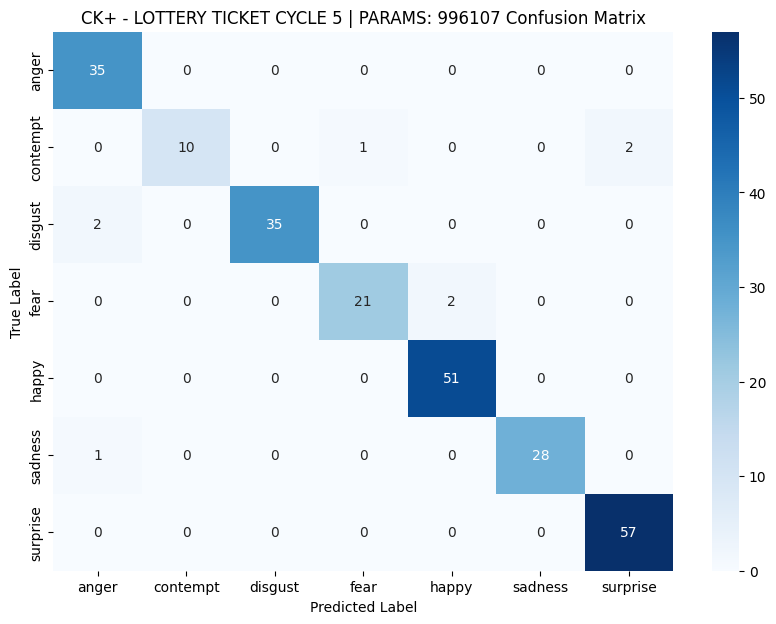

Test Accuracy: 0.9673
Precision: 0.9720
Recall: 0.9420
F1 Score: 0.9543
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      1.00      0.96        35
    contempt       1.00      0.77      0.87        13
     disgust       1.00      0.95      0.97        37
        fear       0.95      0.91      0.93        23
       happy       0.96      1.00      0.98        51
     sadness       1.00      0.97      0.98        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.97       245
   macro avg       0.97      0.94      0.95       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 6, Parameters: 897098, Min Val Loss: 0.0803


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


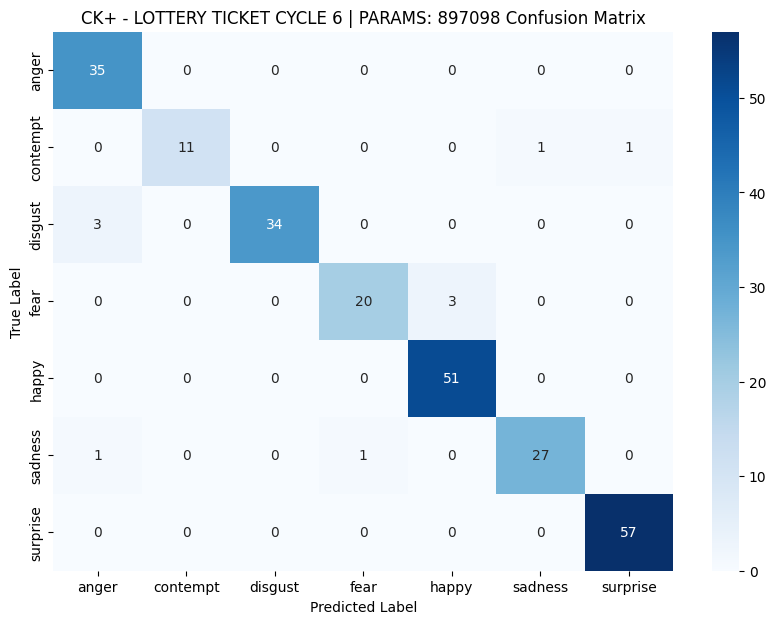

Test Accuracy: 0.9592
Precision: 0.9630
Recall: 0.9380
F1 Score: 0.9485
Classification Report:
               precision    recall  f1-score   support

       anger       0.90      1.00      0.95        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.92      0.96        37
        fear       0.95      0.87      0.91        23
       happy       0.94      1.00      0.97        51
     sadness       0.96      0.93      0.95        29
    surprise       0.98      1.00      0.99        57

    accuracy                           0.96       245
   macro avg       0.96      0.94      0.95       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 7, Parameters: 807994, Min Val Loss: 0.0859


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


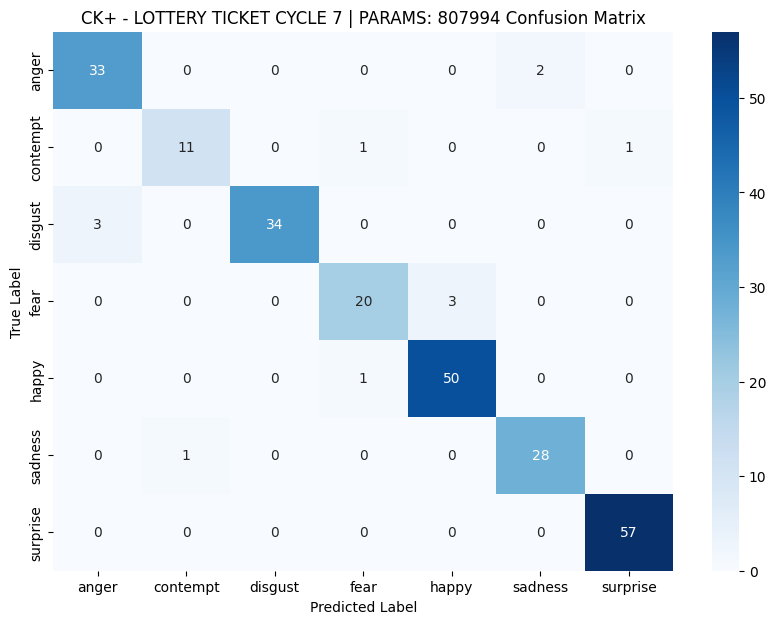

Test Accuracy: 0.9510
Precision: 0.9431
Recall: 0.9319
F1 Score: 0.9369
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.94      0.93        35
    contempt       0.92      0.85      0.88        13
     disgust       1.00      0.92      0.96        37
        fear       0.91      0.87      0.89        23
       happy       0.94      0.98      0.96        51
     sadness       0.93      0.97      0.95        29
    surprise       0.98      1.00      0.99        57

    accuracy                           0.95       245
   macro avg       0.94      0.93      0.94       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 8, Parameters: 727802, Min Val Loss: 0.0910


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


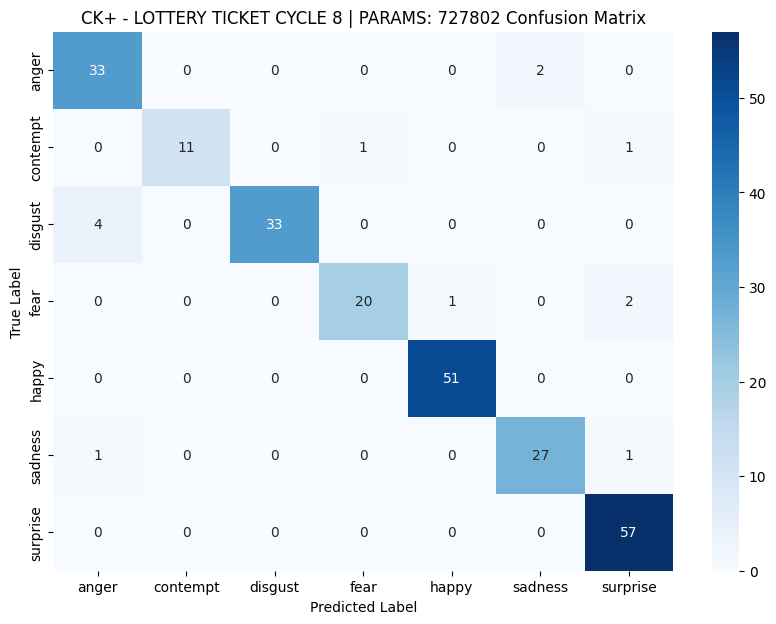

Test Accuracy: 0.9469
Precision: 0.9524
Recall: 0.9259
F1 Score: 0.9372
Classification Report:
               precision    recall  f1-score   support

       anger       0.87      0.94      0.90        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.89      0.94        37
        fear       0.95      0.87      0.91        23
       happy       0.98      1.00      0.99        51
     sadness       0.93      0.93      0.93        29
    surprise       0.93      1.00      0.97        57

    accuracy                           0.95       245
   macro avg       0.95      0.93      0.94       245
weighted avg       0.95      0.95      0.95       245



/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating model from cycle 9, Parameters: 655622, Min Val Loss: 0.0934


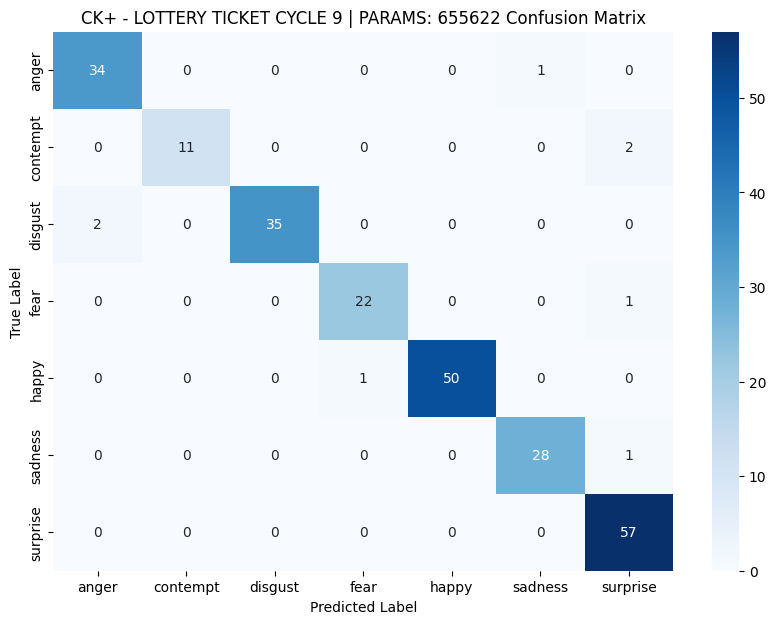

Test Accuracy: 0.9673
Precision: 0.9716
Recall: 0.9523
F1 Score: 0.9607
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.97      0.96        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.95      0.97        37
        fear       0.96      0.96      0.96        23
       happy       1.00      0.98      0.99        51
     sadness       0.97      0.97      0.97        29
    surprise       0.93      1.00      0.97        57

    accuracy                           0.97       245
   macro avg       0.97      0.95      0.96       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 10, Parameters: 590669, Min Val Loss: 0.0714


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


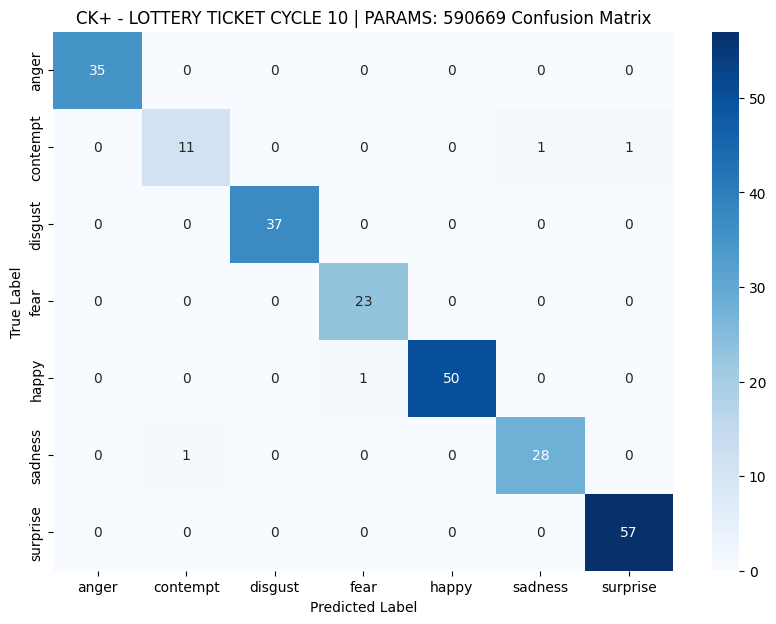

Test Accuracy: 0.9837
Precision: 0.9748
Recall: 0.9703
F1 Score: 0.9722
Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        35
    contempt       0.92      0.85      0.88        13
     disgust       1.00      1.00      1.00        37
        fear       0.96      1.00      0.98        23
       happy       1.00      0.98      0.99        51
     sadness       0.97      0.97      0.97        29
    surprise       0.98      1.00      0.99        57

    accuracy                           0.98       245
   macro avg       0.97      0.97      0.97       245
weighted avg       0.98      0.98      0.98       245

Evaluating model from cycle 11, Parameters: 532205, Min Val Loss: 0.0881


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


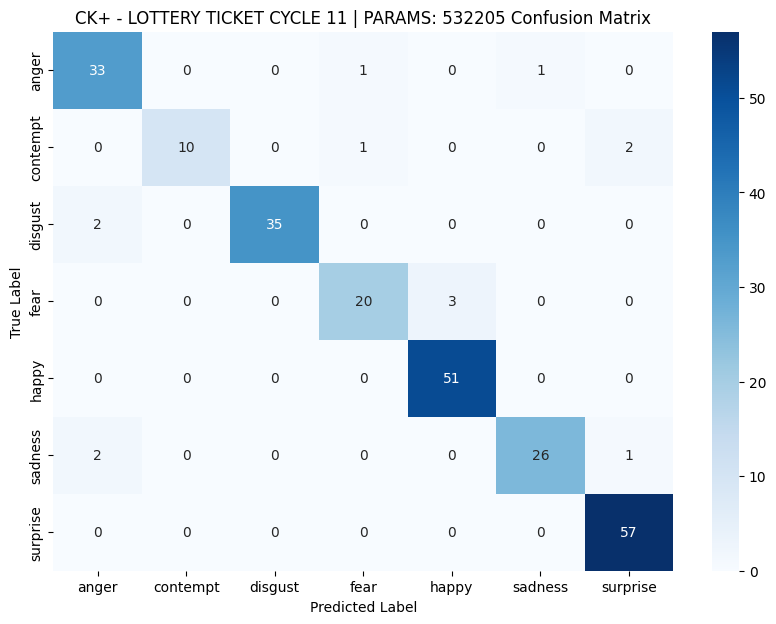

Test Accuracy: 0.9469
Precision: 0.9512
Recall: 0.9177
F1 Score: 0.9317
Classification Report:
               precision    recall  f1-score   support

       anger       0.89      0.94      0.92        35
    contempt       1.00      0.77      0.87        13
     disgust       1.00      0.95      0.97        37
        fear       0.91      0.87      0.89        23
       happy       0.94      1.00      0.97        51
     sadness       0.96      0.90      0.93        29
    surprise       0.95      1.00      0.97        57

    accuracy                           0.95       245
   macro avg       0.95      0.92      0.93       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 12, Parameters: 479587, Min Val Loss: 0.0939


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


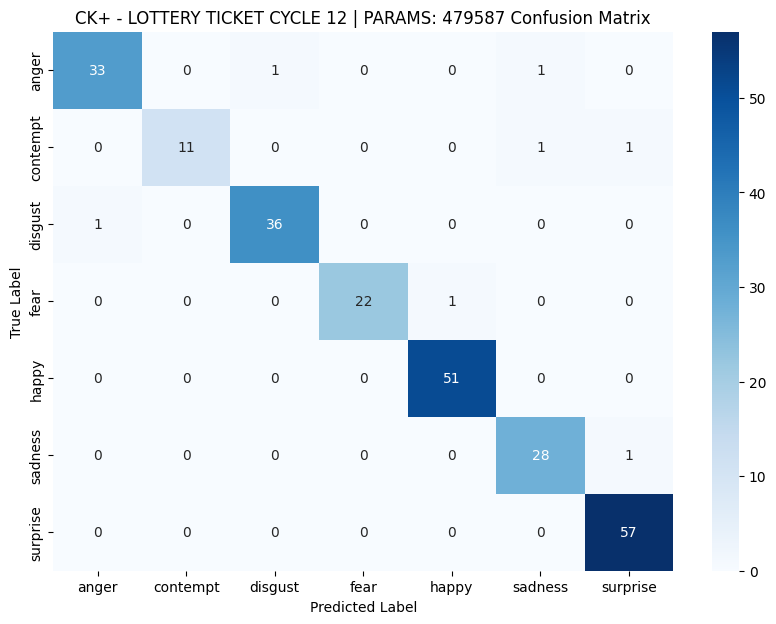

Test Accuracy: 0.9714
Precision: 0.9748
Recall: 0.9549
F1 Score: 0.9637
Classification Report:
               precision    recall  f1-score   support

       anger       0.97      0.94      0.96        35
    contempt       1.00      0.85      0.92        13
     disgust       0.97      0.97      0.97        37
        fear       1.00      0.96      0.98        23
       happy       0.98      1.00      0.99        51
     sadness       0.93      0.97      0.95        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.97       245
   macro avg       0.97      0.95      0.96       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 13, Parameters: 432237, Min Val Loss: 0.0959


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


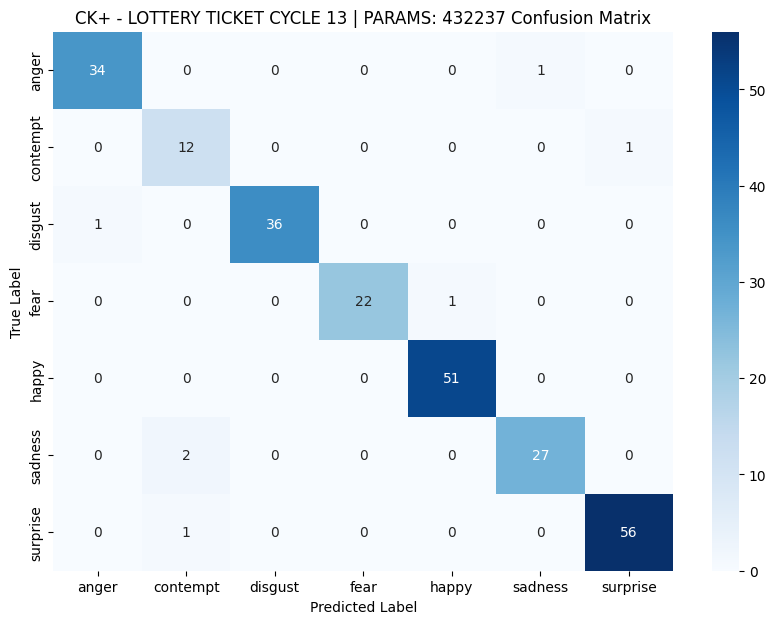

Test Accuracy: 0.9714
Precision: 0.9570
Recall: 0.9625
F1 Score: 0.9590
Classification Report:
               precision    recall  f1-score   support

       anger       0.97      0.97      0.97        35
    contempt       0.80      0.92      0.86        13
     disgust       1.00      0.97      0.99        37
        fear       1.00      0.96      0.98        23
       happy       0.98      1.00      0.99        51
     sadness       0.96      0.93      0.95        29
    surprise       0.98      0.98      0.98        57

    accuracy                           0.97       245
   macro avg       0.96      0.96      0.96       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 14, Parameters: 389614, Min Val Loss: 2.3430


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

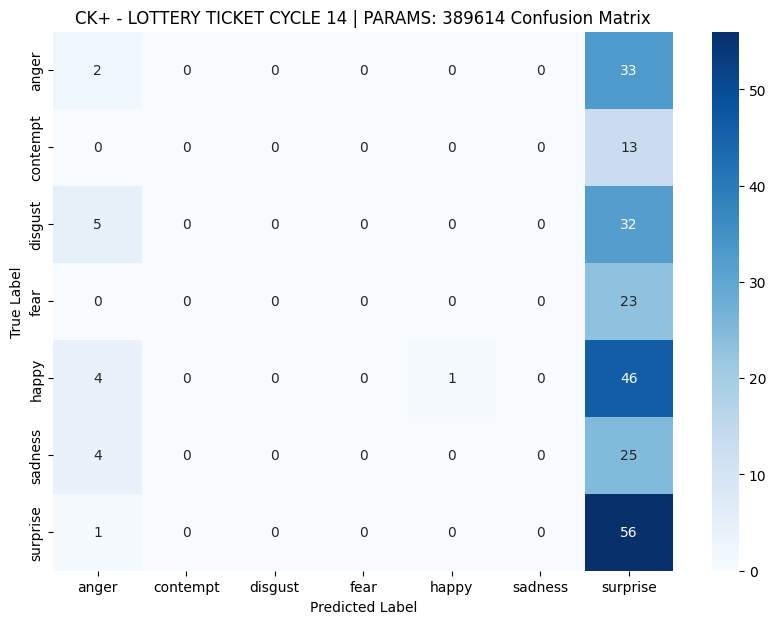

Test Accuracy: 0.2408
Precision: 0.1958
Recall: 0.1513
F1 Score: 0.0728
Classification Report:
               precision    recall  f1-score   support

       anger       0.12      0.06      0.08        35
    contempt       0.00      0.00      0.00        13
     disgust       0.00      0.00      0.00        37
        fear       0.00      0.00      0.00        23
       happy       1.00      0.02      0.04        51
     sadness       0.00      0.00      0.00        29
    surprise       0.25      0.98      0.39        57

    accuracy                           0.24       245
   macro avg       0.20      0.15      0.07       245
weighted avg       0.28      0.24      0.11       245

Evaluating model from cycle 15, Parameters: 351256, Min Val Loss: 2.3716


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

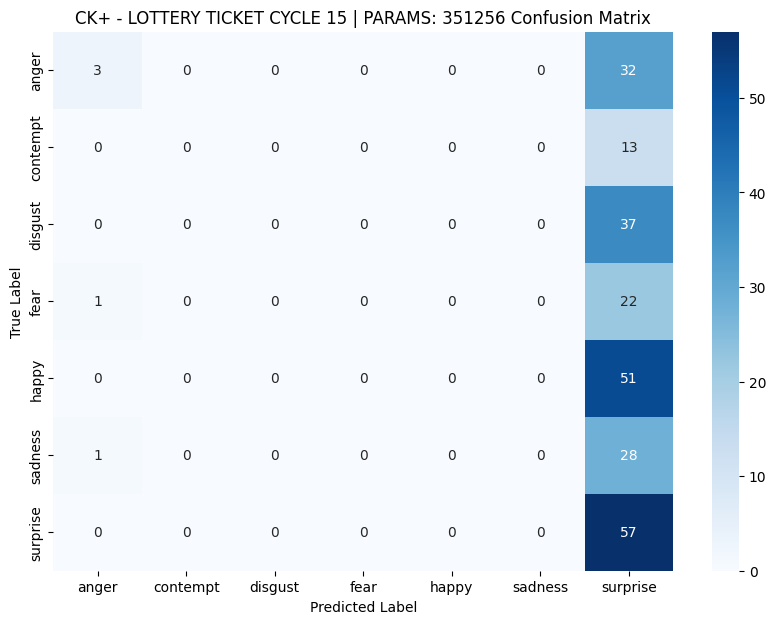

Test Accuracy: 0.2449
Precision: 0.1196
Recall: 0.1551
F1 Score: 0.0763
Classification Report:
               precision    recall  f1-score   support

       anger       0.60      0.09      0.15        35
    contempt       0.00      0.00      0.00        13
     disgust       0.00      0.00      0.00        37
        fear       0.00      0.00      0.00        23
       happy       0.00      0.00      0.00        51
     sadness       0.00      0.00      0.00        29
    surprise       0.24      1.00      0.38        57

    accuracy                           0.24       245
   macro avg       0.12      0.16      0.08       245
weighted avg       0.14      0.24      0.11       245

Evaluating model from cycle 16, Parameters: 316734, Min Val Loss: 2.6385


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

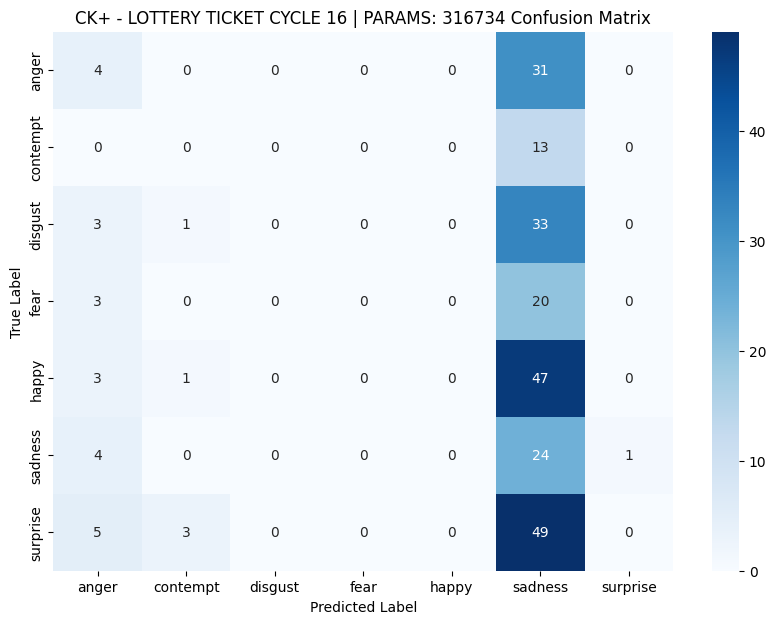

Test Accuracy: 0.1143
Precision: 0.0418
Recall: 0.1346
F1 Score: 0.0479
Classification Report:
               precision    recall  f1-score   support

       anger       0.18      0.11      0.14        35
    contempt       0.00      0.00      0.00        13
     disgust       0.00      0.00      0.00        37
        fear       0.00      0.00      0.00        23
       happy       0.00      0.00      0.00        51
     sadness       0.11      0.83      0.20        29
    surprise       0.00      0.00      0.00        57

    accuracy                           0.11       245
   macro avg       0.04      0.13      0.05       245
weighted avg       0.04      0.11      0.04       245

Evaluating model from cycle 17, Parameters: 285667, Min Val Loss: 19.8866


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

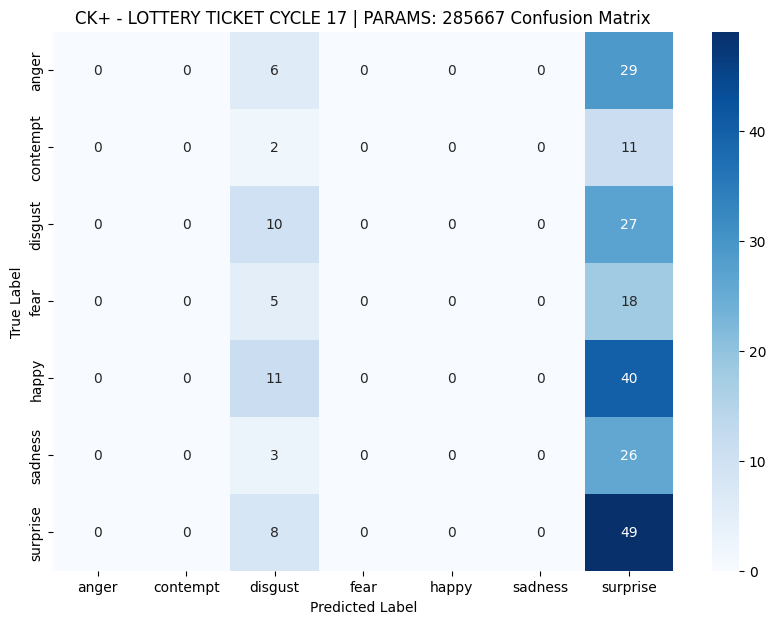

Test Accuracy: 0.2408
Precision: 0.0667
Recall: 0.1614
F1 Score: 0.0893
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
    contempt       0.00      0.00      0.00        13
     disgust       0.22      0.27      0.24        37
        fear       0.00      0.00      0.00        23
       happy       0.00      0.00      0.00        51
     sadness       0.00      0.00      0.00        29
    surprise       0.24      0.86      0.38        57

    accuracy                           0.24       245
   macro avg       0.07      0.16      0.09       245
weighted avg       0.09      0.24      0.13       245

Evaluating model from cycle 18, Parameters: 257700, Min Val Loss: 238.1760


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

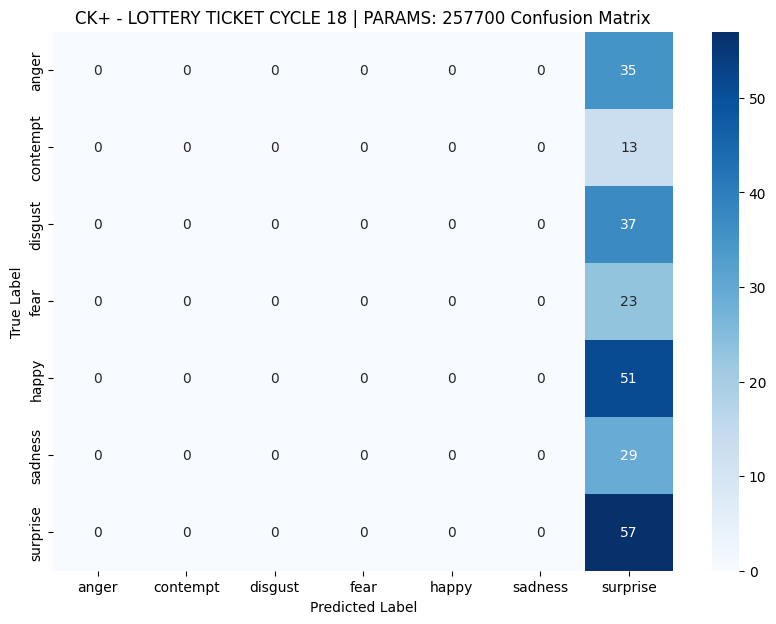

Test Accuracy: 0.2327
Precision: 0.0332
Recall: 0.1429
F1 Score: 0.0539
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
    contempt       0.00      0.00      0.00        13
     disgust       0.00      0.00      0.00        37
        fear       0.00      0.00      0.00        23
       happy       0.00      0.00      0.00        51
     sadness       0.00      0.00      0.00        29
    surprise       0.23      1.00      0.38        57

    accuracy                           0.23       245
   macro avg       0.03      0.14      0.05       245
weighted avg       0.05      0.23      0.09       245

Evaluating model from cycle 19, Parameters: 232540, Min Val Loss: 7.9378


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

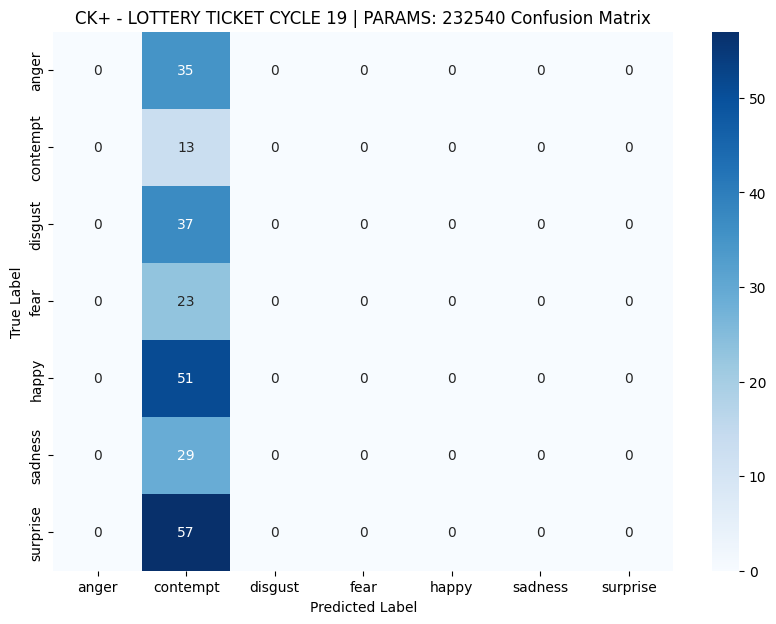

Test Accuracy: 0.0531
Precision: 0.0076
Recall: 0.1429
F1 Score: 0.0144
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
    contempt       0.05      1.00      0.10        13
     disgust       0.00      0.00      0.00        37
        fear       0.00      0.00      0.00        23
       happy       0.00      0.00      0.00        51
     sadness       0.00      0.00      0.00        29
    surprise       0.00      0.00      0.00        57

    accuracy                           0.05       245
   macro avg       0.01      0.14      0.01       245
weighted avg       0.00      0.05      0.01       245



In [11]:
def evaluate_all_models(best_models_dict, test_loader, device, data, label_encoder=None):
    for cycle, model_info in best_models_dict.items():
        model_state_dict = model_info['model']
        params = model_info['params']
        min_val_loss = model_info['min_val_loss']

        model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)
        model.load_state_dict(model_state_dict)

        title = f'{data.upper()} - Lottery Ticket Cycle {cycle} | Params: {params}'

        print(f"Evaluating model from cycle {cycle}, Parameters: {params}, Min Val Loss: {min_val_loss:.4f}")

        evaluate_model(model, test_loader, device, title, label_encoder=label_encoder)


evaluate_all_models(best_models_dict, test_loader, device, data="CK+", label_encoder=label_encoder)


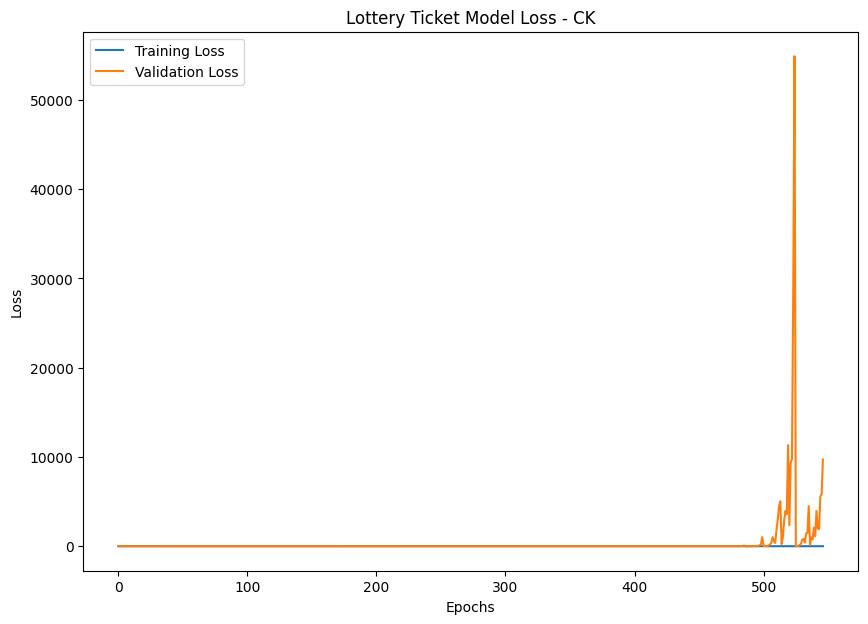

In [12]:
plot_losses(train_loss, 
            val_loss, 
            f'Lottery Ticket Model Loss - {data.upper()}')

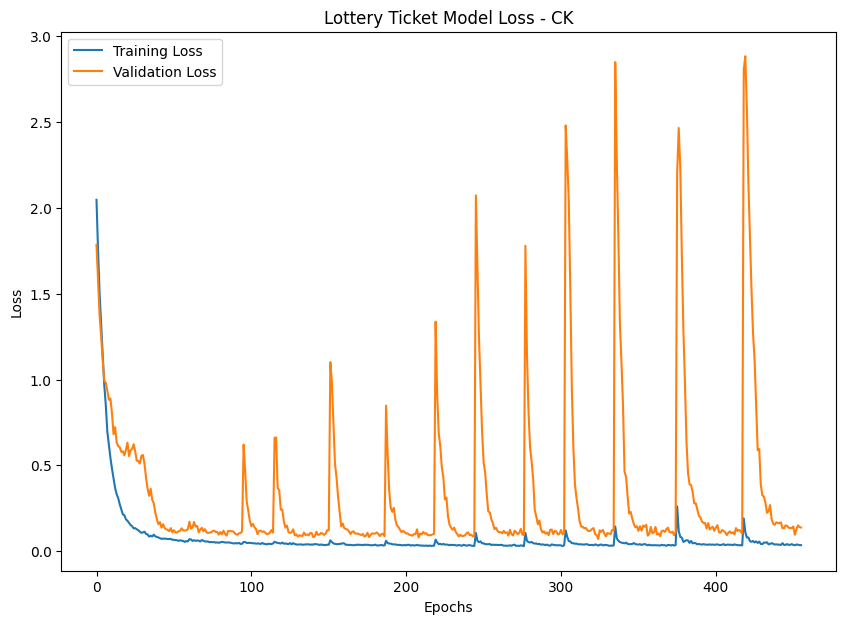

In [25]:
plot_losses(train_loss[:456],
            val_loss[:456],
            f'Lottery Ticket Model Loss - {data.upper()}')

In [13]:
min(train_loss)

0.029026777483522892

In [14]:
min(val_loss)

0.07144093990791589